In [171]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate as interpolate
import types
import algopy
import lmfit

import mpmath

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=15)

# Helper functions

In [172]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    for i in range(0, int((maxWl-minWl) / period)):
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
    return result

# Classes that define simulated instruments.

In [196]:
class Spectrograph:
    def __init__(self, xres, bgrNoiseMu, bgrNoiseSD, minWl, maxWl, fhwm, precision):
        self.xres = xres
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.minWl = minWl
        self.maxWl = maxWl
        self.sigma = fhwm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.precision = precision
        self.fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl) # Constantly used in conversions
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    def observe(self, beams):
        space = np.linspace(self.minWl, self.maxWl, self.xres)
        observation = np.zeros(len(space))
        
        bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(space)) # Background noise
        bgrNoise[bgrNoise < 0.0] = 0.0
        observation += bgrNoise
        
        # Each ray in a beam becomes a gaussian
        for beam in beams:
            for wl in beam:
                observation += gauss(space, wl, self.sigma, beam[wl])
        
        # Add shot noise
        observation += np.random.normal(0.0, np.sqrt(observation) * self.precision / 2, len(space))
        
        # Spectrograph has no notion of wavelength, space must be in pixels
        return np.linspace(0, self.xres, self.xres), observation
    
    def pix_to_wl(self, pix):
        return self.minWl + (pix / self.fac)
        
    def wl_to_pix(self, wl):
        return (wl - sgraph.minWl) * self.fac
        
class LFC:
    def __init__(self, intensity, minWl, maxWl, dWl):
        self.intensity = intensity
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current = self.minWl
        while current <= self.maxWl:
            sim[current] = self.intensity
            current += self.dWl
        return sim

# Finding maxima

In [197]:
def get_peaks(shift, lfc, n):
    peaks = np.empty(0)
    current = shift
    for i in range(0, n):
        peaks = np.append(peaks, current)
        current += lfc.dWl
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y):
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=10)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return guess_x, guess_y
    
def find_lfc_peaks(sgraph, lfc):
    lfc_peaks = lfc.getPeaks()
    
    def per_gauss_fit(wl, minWl):
        return per_gauss(wl, sgraph.sigma * sgraph.fac, minWl, minWl + (len(lfc_peaks)) * lfc.dWl * sgraph.fac, 
                         lfc.dWl * sgraph.fac, lfc.intensity)
    
    print('Solution is: {}pix or {}nm'.format(wl_to_pix(lfc.minWl, sgraph), lfc.minWl))

    x, y = sgraph.observe([lfc.simulate()])
    
    # Do a cubic interpolation of x and y 
    spl = interpolate.UnivariateSpline(x, y, k=3)
    # ss stands for supersampled
    ss_x = np.linspace(0, sgraph.xres, 20000, dtype=np.float64)
    ss_y = spl(ss_x)
#     ss_x = x
#     ss_y = y
    ss_y[ss_y <= 0.0] = 1e-15
    
    # Fit on interpolated data
    guess_x, guess_y = guess_min(ss_x, ss_y)
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    # Use lmfit for fitting
    gmod = lmfit.Model(per_gauss_fit)
    result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
#     result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='leastsq', 
#                       options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift = result.params['minWl'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
    
    pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    
    print(lfc_peaks[0:3], lfc_peaks[-3:])
    print(pred_peaks[0:3], pred_peaks[-3:])
    
    lse, error = pred_error(ss_y, y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    plt.scatter(ss_x, ss_y, color='blue')
    plt.scatter(x, y, color='magenta')
    plt.plot(ss_x, y_pred, color='red')
    for peak in pred_peaks:
        plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='green')
    for peak in lfc_peaks:
        plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='purple')
    plt.axvline(guess_x, color='turquoise')
    plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
    fig = plt.show()
    
    return ss_x, ss_y, pred_shift

In [198]:
rand = np.random.random(1)[0]
# lfc = LFC(250000, 0.0075, 400 + rand, 410 + rand, 1.0/31.0)
# sgraph = Spectrograph(4000, 1000.0, 300.0, 399.0, 411.0, 1.0)
lfc = LFC(250000, 400 + rand, 410 + rand, 0.03)
sgraph = Spectrograph(4000, 1000.0, 300.0, 399.0, 411.0, 0.0075, 1.0)

Solution is: 365.187682745pix or 400.095563048nm
Initial guess for shift is: [ 365.218260913045697]pix or 400.095654783nm
 - Adding parameter "minWl"
Predicted shift is: [ 365.187728151939609]pix or 400.095563184nm
Number of calls: 87
(array([ 400.095563048233771,  400.125563048233744,  400.155563048233716]), array([ 410.02556304822474 ,  410.055563048224712,  410.085563048224685]))
(array([ 400.095563184455841,  400.125563184455814,  400.155563184455787]), array([ 410.02556318444681 ,  410.055563184446783,  410.085563184446755]))
Least squares error is 1174.57649886
Error is: 0.102142150013m/s


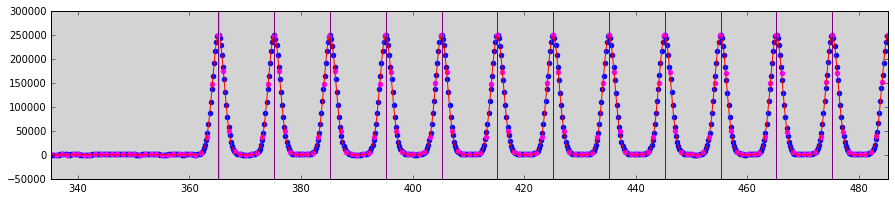

CPU times: user 16.2 s, sys: 13.3 ms, total: 16.2 s
Wall time: 16.2 s


In [204]:
%%time
ss_x, ss_y, pred_shift = find_lfc_peaks(sgraph, lfc)

# Notes
**For future**:
- Make a table of effect of increasing the lfc intensity
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order
- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
- Paper submission to PASP

**Open questions**:
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity